# March 16th, 2021

**Motivation**: The effect of bandpass filtering on community structure.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
def filter_boundaries(x, dim: int = 2):
    if dim == 2:
        bad_x_indices = np.where(x.mean(-1).mean(1) == 0)[0]
        bad_y_indices = np.where(x.mean(-1).mean(0) == 0)[0]
        x = np.delete(np.delete(x, bad_y_indices, axis=1), bad_x_indices, axis=0)
    elif dim == 3:
        raise NotImplementedError
    else:
        raise ValueError("wrong dim")
    return x


def filter_islands(partition, labels, scale: int, min_com_size: int = 5):
    coms_ctr = collections.Counter(partition.values())
    good_com_idxs = tuple(zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common())))[0]
    
    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)

    comm_mat = np.ones((scale, scale)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        com_idx = partition[node_idx]
        if com_idx in good_com_idxs:
            comm_mat[i, j] = good_com_idxs.index(com_idx)
        else:
            comm_mat[i, j] = np.nan
    
    return comm_mat, comm_dict

## Closer look at possible data flaws

I choose a dataset that looks OK from subject named **sub-SLC08**.  Then I will describe a systematic way of examining data quality.  I don't think serious flaws such as sudden drastic jumps are that frequent.

In [3]:
# HIDE CODE


expt_seconds = 600   # 600 seconds
ca_fs = 10
exclude_seconds = 60
good_timepoints = (expt_seconds - exclude_seconds) * ca_fs

filter_fn = lambda x: 'ca' in x and 'ses-1' in x and 'sub-SLC06' in x and 'rest' in x
files = sorted(list(filter(filter_fn, os.listdir(processed_dir))))

data_list = []
for load_filename in files:
    ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
    data_list.append(ca[..., 0, range(ca.shape[-1] - good_timepoints, ca.shape[-1])])
ca = filter_boundaries(np.concatenate(data_list, axis=-1), dim=2)

print("Data from {:d} runs loaded:\n".format(len(files)))
pprint(files)

msg = '\n-->  {:d} s  <-- excluded from the beginning of each run. Combined runs duration:'
msg = msg.format(exclude_seconds)
print(msg)
convert_time(ca.shape[-1] / ca_fs)

Data from 4 runs loaded:

['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-7_task-rest_ca.npy']

-->  60 s  <-- excluded from the beginning of each run. Combined runs duration:

00 - 00:36:00  (dd - hh:mm:ss)



In [4]:
npix_x, npix_y, nt = ca.shape
npix_x, npix_y, nt

(190, 186, 21600)

In [5]:
window = 100
num = int(np.ceil(nt/window))

sigma = np.zeros((npix_x, npix_y, num))
for n in tqdm(range(num), leave=False):
    start = n*window
    end = min(nt, (n+1)*window)
    sigma[..., n] = np.var(ca[..., start:end], axis=-1)

sigma /= sigma.sum(-1, keepdims=True)
sigma_avg = sigma.mean(-1)
sigma_std = sigma.std(-1)
indxs_sorted = np.argsort(sigma, axis=-1)[::-1]

sigma.shape

(190, 186, 216)

In [6]:
num_stds = 5

sns.set_style('whitegrid')
anomalies = {}
for i in tqdm(range(npix_x), leave=False):
    for j in range(npix_y):
        _anomalies = []
        for t in indxs_sorted[i, j]:
            if sigma[i, j, t] - sigma_avg[i, j] > num_stds * sigma_std[i, j]:
                _anomalies.append(t)
        anomalies['{:d},{:d}'.format(i, j)] = _anomalies
        
print('{:.0f} {:s} of all pixels contain at least one anomalous time period'.format(
    len(list(filter(lambda x: len(x), anomalies.values()))) / (npix_x * npix_y) * 100, '%',
))

40 % of all pixels contain at least one anomalous time period


In [7]:
all_indxs = []
dict_list = []
for k, v in anomalies.items():
    if len(v):
        all_indxs.extend(v)
        i, j = tuple(map(lambda x: int(x), k.split(',')))
        data_dict = {
            'idx': range(num),
            'ratio': [len(v) / num] * num,
            'sigma': sigma[i, j],
        }
        dict_list.append(data_dict)
    
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

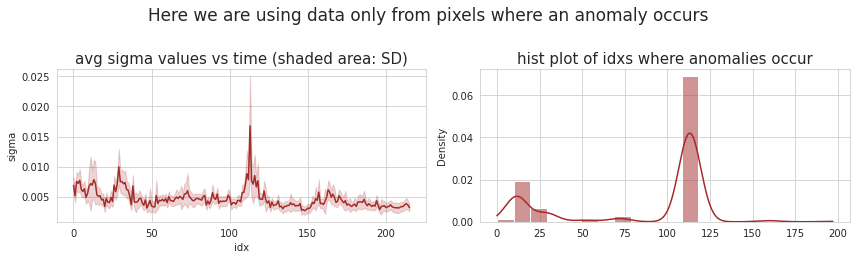

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))

sns.lineplot(data=df, x='idx', y='sigma', ci='sd', color='brown', ax=ax1)
sns.histplot(all_indxs, kde=True, color='brown', stat='density', bins=20, ax=ax2)

ax1.set_title('avg sigma values vs time (shaded area: SD)', fontsize=15)
ax2.set_title('hist plot of idxs where anomalies occur', fontsize=15)

fig.suptitle('Here we are using data only from pixels where an anomaly occurs', fontsize=17, y=1.02)

fig.tight_layout()
plt.show()

In [19]:
most_common_anomalous_idxs = collections.Counter(all_indxs).most_common()[:5]
most_common_anomalous_idxs

[(113, 10280), (11, 1691), (29, 1011), (13, 602), (14, 434)]

## Bandpass filtering

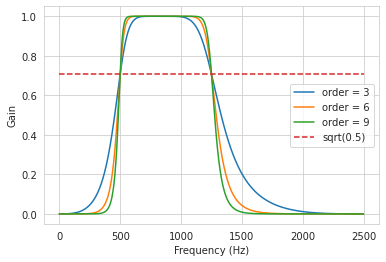

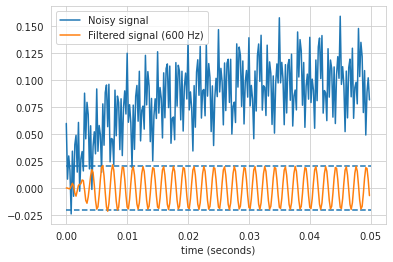

In [10]:
from scipy.signal import butter, lfilter, lfilter_zi

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a)
    y, zo = lfilter(b, a, data, zi=zi*data[0])
    return y, zo


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y, zo = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

In [11]:
from scipy import signal

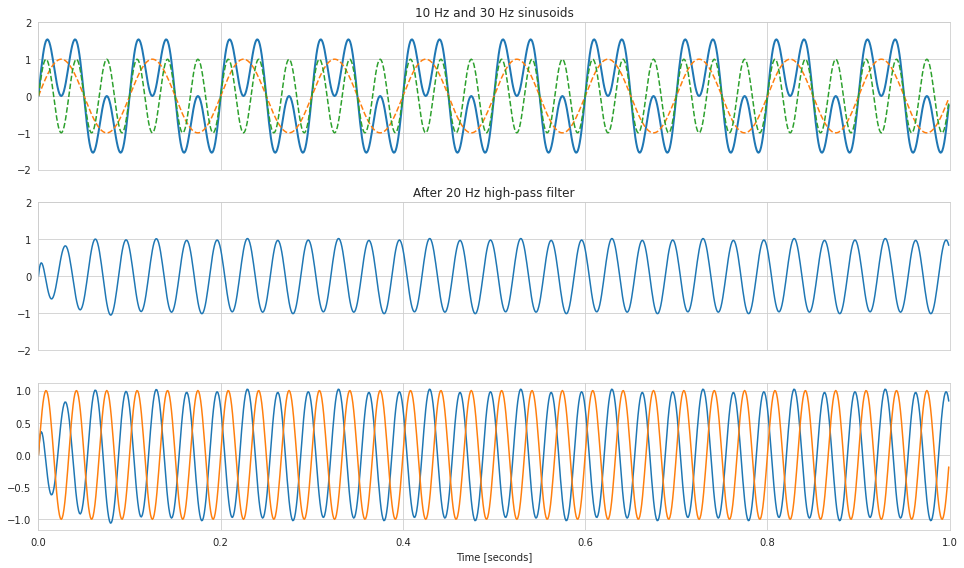

In [12]:
t = np.linspace(0, 1, 1000, False)  # 1 second
f1 = 10
f2 = 30
sig1 = np.sin(2*np.pi*f1*t)
sig2 = np.sin(2*np.pi*f2*t)
sig = sig1 + sig2
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13.5, 8), sharex=True)
ax1.plot(t, sig, lw=2)
ax1.plot(t, sig1, ls='--')
ax1.plot(t, sig2, ls='--')
ax1.set_title('{:d} Hz and {:d} Hz sinusoids'.format(f1, f2))
ax1.axis([0, 1, -2, 2])


hp_f = 20
sos = signal.butter(5, hp_f, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After {:d} Hz high-pass filter'.format(hp_f))
ax2.axis([0, 1, -2, 2])
ax3.set_xlabel('Time [seconds]')

ax3.plot(t, filtered)
ax3.plot(t, sig2)

plt.tight_layout()
plt.show()

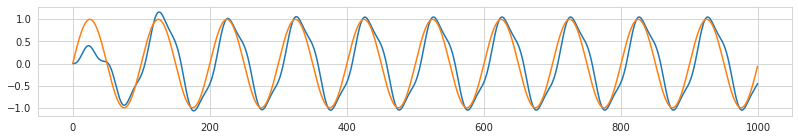

In [13]:
y, zo = butter_bandpass_filter(data=sig, lowcut=5, highcut=15, fs=1000, order=2)

plt.figure(figsize=(13.5, 2))
plt.plot(y)
plt.plot(sig1)

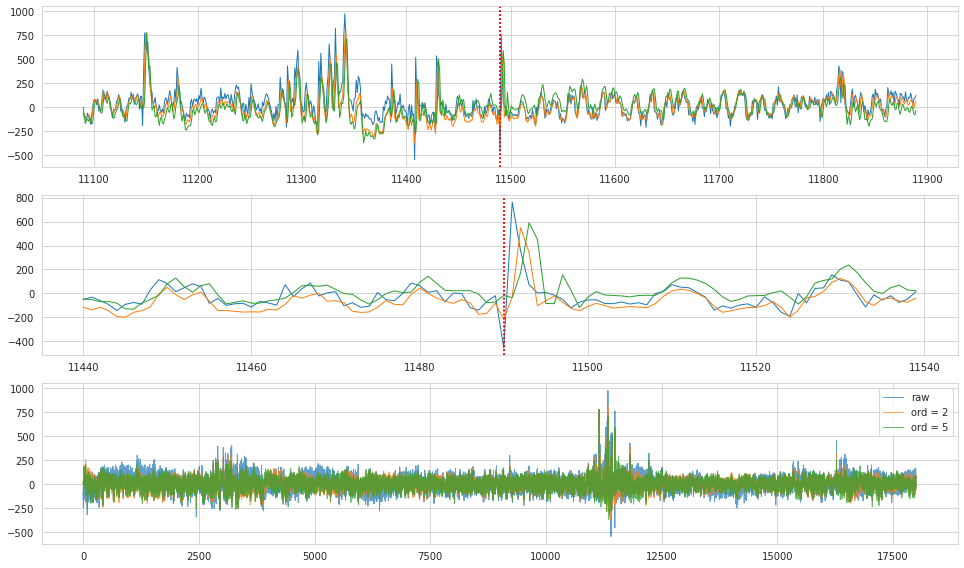

In [14]:
lowcut, highcut = 0.01, 3

data = ca[126, 139].copy()

y10, zo = butter_bandpass_filter(
    data=data,
    lowcut=lowcut,
    highcut=highcut,
    fs=ca_fs,
    order=5,
)

y, zo = butter_bandpass_filter(
    data=data,
    lowcut=lowcut,
    highcut=highcut,
    fs=ca_fs,
    order=2,
)

plotting_dict = {'raw': data, 'ord = 2': y, 'ord = 5': y10}


fig, axes = plt.subplots(3, 1, figsize=(13.5, 8))
for name, v in plotting_dict.items():
    intvl = range(11490 - 400, 11490 + 400)
    axes[0].plot(intvl, v[intvl], lw=1, label=name)
    axes[0].axvline(11490, color='red', ls=':', lw=1.5)

    intvl = range(11490 - 50, 11490 + 50)
    axes[1].plot(intvl, v[intvl], lw=1, label=name)
    axes[1].axvline(11490, color='red', ls=':', lw=1.5)

    intvl = range(0, 18000)
    axes[2].plot(intvl, v[intvl], lw=1, alpha=0.7, label=name)

axes[-1].legend()
fig.tight_layout()
plt.show()

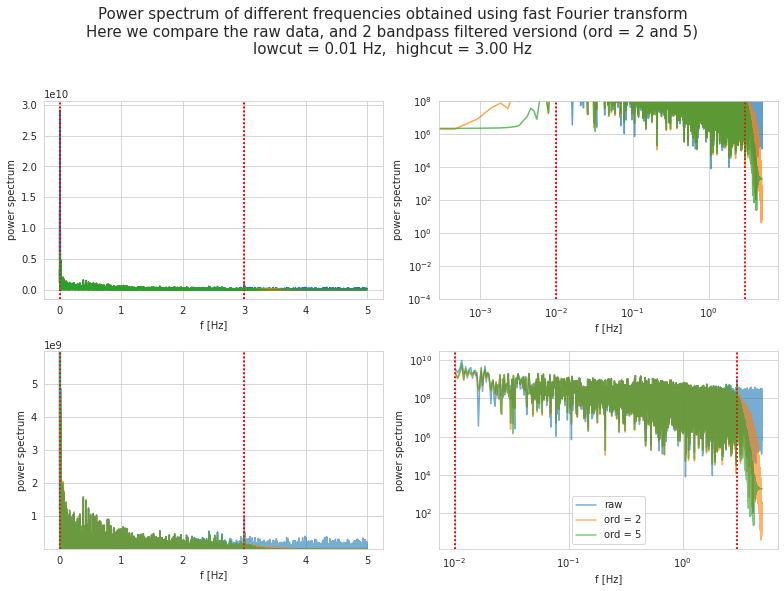

In [15]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

for name, v in plotting_dict.items():
    fourier_transform = np.fft.rfft(v)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, ca_fs / 2, len(fourier_transform))

    low_idx = (np.abs(frequency - lowcut)).argmin()
    high_idx = (np.abs(frequency - highcut)).argmin()

    axes[0, 0].plot(frequency, power_spectrum)
    axes[0, 1].loglog(frequency, power_spectrum, alpha=0.7)
    axes[0, 1].set_ylim(1e-4, 1e8)
    
    axes[1, 0].plot(frequency, power_spectrum, alpha=0.6)
    axes[1, 0].set_ylim(min(power_spectrum[low_idx:high_idx]), max(power_spectrum[low_idx:high_idx]))
    axes[1, 1].loglog(frequency[low_idx:], power_spectrum[low_idx:], alpha=0.6, label=name)

    for i in range(2):
        for j in range(2):
            axes[i, j].axvline(lowcut, color='r', ls=':')
            axes[i, j].axvline(highcut, color='r', ls=':')
            axes[i, j].set_xlabel('f [Hz]')
            axes[i, j].set_ylabel('power spectrum')
axes[1, 1].legend(loc='lower center')
msg = 'Power spectrum of different frequencies obtained using fast Fourier transform\n'
msg += 'Here we compare the raw data, and 2 bandpass filtered versiond (ord = 2 and 5)\n'
msg += 'lowcut = {:.2f} Hz,  highcut = {:.2f} Hz'.format(lowcut, highcut)
fig.suptitle(msg, y=1.02, fontsize=15)
fig.tight_layout()
plt.show()

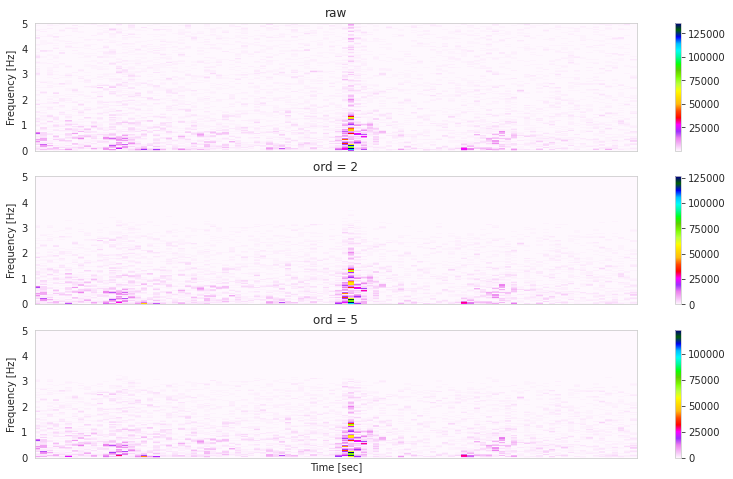

In [16]:

fig, axes = plt.subplots(3, 1, figsize=(13.5, 8), sharex='col')

for i, (name, v) in enumerate(plotting_dict.items()):
    f, t, Sxx = signal.spectrogram(v, ca_fs, window='hamming')
    # Sxx /= Sxx.sum(0)
    im = axes[i].pcolormesh(t, f, Sxx, shading='nearest', cmap='gist_ncar_r')
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])

axes[-1].set_xticks([])
axes[-1].set_xlabel('Time [sec]')

plt.show()

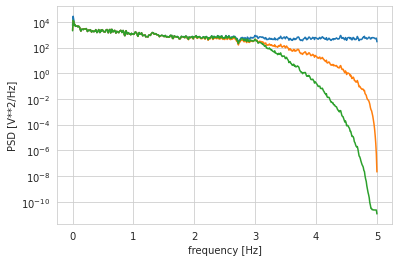

In [17]:
f, Pxx_den = signal.welch(data, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

f, Pxx_den = signal.welch(y, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

f, Pxx_den = signal.welch(y10, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Delete problematic time points

In [20]:
most_common_anomalous_idxs

[(113, 10280), (11, 1691), (29, 1011), (13, 602), (14, 434)]

In [22]:
delete_indxs = []
for idx, _ in most_common_anomalous_idxs:
    delete_indxs.extend(range((idx-1)*window, (idx+1)*window))
delete_indxs = list(sorted(np.unique(delete_indxs)))
    
ca_filtered = np.delete(ca, delete_indxs, axis=-1)
ca_filtered.shape, ca.shape

((190, 186, 20700), (190, 186, 21600))

In [23]:
window = 100
num = int(np.ceil(nt/window))

sigma = np.zeros((npix_x, npix_y, num))
for n in tqdm(range(num), leave=False):
    start = n*window
    end = min(nt, (n+1)*window)
    sigma[..., n] = np.var(ca_filtered[..., start:end], axis=-1)

sigma /= sigma.sum(-1, keepdims=True)
sigma_avg = sigma.mean(-1)
sigma_std = sigma.std(-1)
indxs_sorted = np.argsort(sigma, axis=-1)[::-1]

sigma.shape

(190, 186, 216)

In [29]:
num_stds = 5

sns.set_style('whitegrid')
anomalies = {}
for i in tqdm(range(npix_x), leave=False):
    for j in range(npix_y):
        _anomalies = []
        for t in indxs_sorted[i, j]:
            if sigma[i, j, t] - sigma_avg[i, j] > num_stds * sigma_std[i, j]:
                _anomalies.append(t)
        anomalies['{:d},{:d}'.format(i, j)] = _anomalies
        
print('{:.0f} {:s} of all pixels contain at least one anomalous time period'.format(
    len(list(filter(lambda x: len(x), anomalies.values()))) / (npix_x * npix_y) * 100, '%',
))

0 % of all pixels contain at least one anomalous time period


## Bandpass filtering

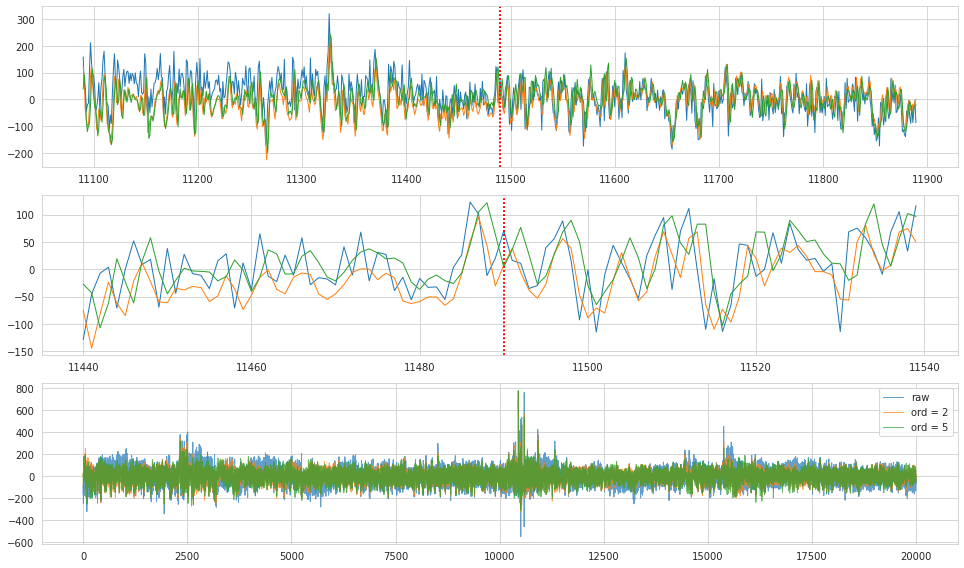

In [43]:
lowcut, highcut = 0.01, 3

data = ca_filtered[126, 139].copy()

y10, zo = butter_bandpass_filter(
    data=data,
    lowcut=lowcut,
    highcut=highcut,
    fs=ca_fs,
    order=5,
)

y, zo = butter_bandpass_filter(
    data=data,
    lowcut=lowcut,
    highcut=highcut,
    fs=ca_fs,
    order=2,
)

plotting_dict = {'raw': data, 'ord = 2': y, 'ord = 5': y10}


fig, axes = plt.subplots(3, 1, figsize=(13.5, 8))
for name, v in plotting_dict.items():
    intvl = range(11490 - 400, 11490 + 400)
    axes[0].plot(intvl, v[intvl], lw=1, label=name)
    axes[0].axvline(11490, color='red', ls=':', lw=1.5)

    intvl = range(11490 - 50, 11490 + 50)
    axes[1].plot(intvl, v[intvl], lw=1, label=name)
    axes[1].axvline(11490, color='red', ls=':', lw=1.5)

    intvl = range(0, 20000)
    axes[2].plot(intvl, v[intvl], lw=1, alpha=0.7, label=name)

axes[-1].legend()
fig.tight_layout()
plt.show()

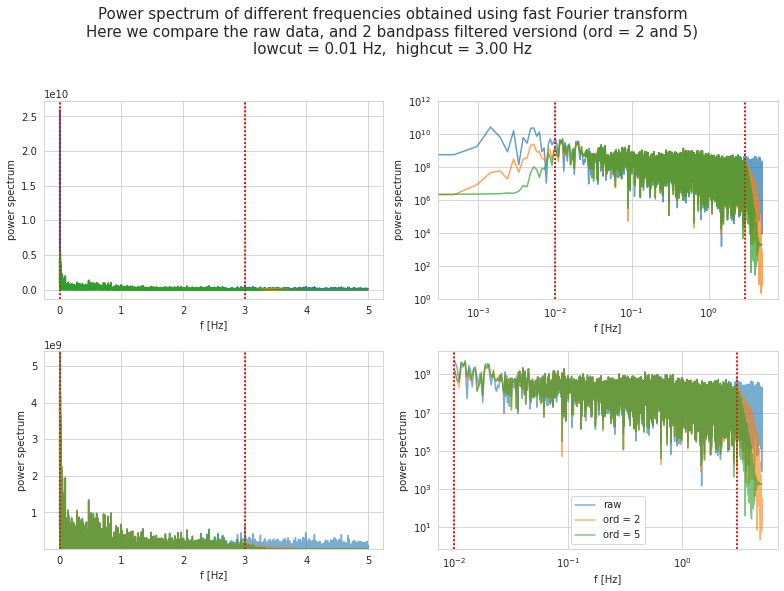

In [44]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

for name, v in plotting_dict.items():
    fourier_transform = np.fft.rfft(v)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, ca_fs / 2, len(fourier_transform))

    low_idx = (np.abs(frequency - lowcut)).argmin()
    high_idx = (np.abs(frequency - highcut)).argmin()

    axes[0, 0].plot(frequency, power_spectrum)
    axes[0, 1].loglog(frequency, power_spectrum, alpha=0.7)
    axes[0, 1].set_ylim(1e0, 1e12)
    
    axes[1, 0].plot(frequency, power_spectrum, alpha=0.6)
    axes[1, 0].set_ylim(min(power_spectrum[low_idx:high_idx]), max(power_spectrum[low_idx:high_idx]))
    axes[1, 1].loglog(frequency[low_idx:], power_spectrum[low_idx:], alpha=0.6, label=name)

    for i in range(2):
        for j in range(2):
            axes[i, j].axvline(lowcut, color='r', ls=':')
            axes[i, j].axvline(highcut, color='r', ls=':')
            axes[i, j].set_xlabel('f [Hz]')
            axes[i, j].set_ylabel('power spectrum')
axes[1, 1].legend(loc='lower center')
msg = 'Power spectrum of different frequencies obtained using fast Fourier transform\n'
msg += 'Here we compare the raw data, and 2 bandpass filtered versiond (ord = 2 and 5)\n'
msg += 'lowcut = {:.2f} Hz,  highcut = {:.2f} Hz'.format(lowcut, highcut)
fig.suptitle(msg, y=1.02, fontsize=15)
fig.tight_layout()
plt.show()

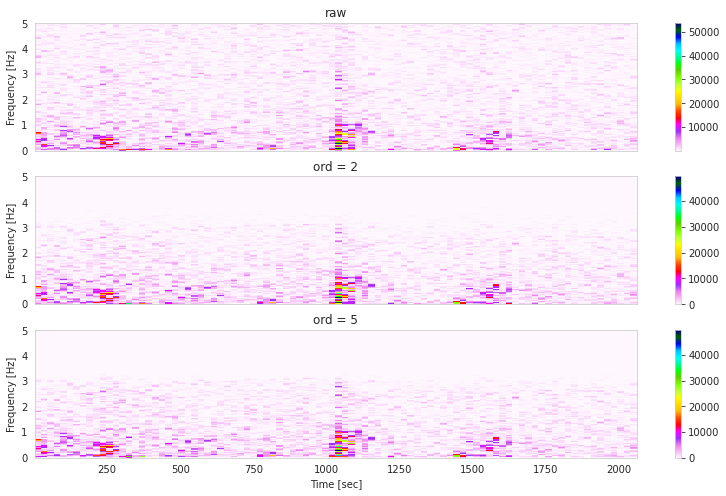

In [40]:

fig, axes = plt.subplots(3, 1, figsize=(13.5, 8), sharex='col')

for i, (name, v) in enumerate(plotting_dict.items()):
    f, t, Sxx = signal.spectrogram(v, ca_fs, window='hamming')
    # Sxx /= Sxx.sum(0)
    im = axes[i].pcolormesh(t, f, Sxx, shading='nearest', cmap='gist_ncar_r')
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_title(name)
    plt.colorbar(im, ax=axes[i])

# axes[-1].set_xticks()
axes[-1].set_xlabel('Time [sec]')

plt.show()

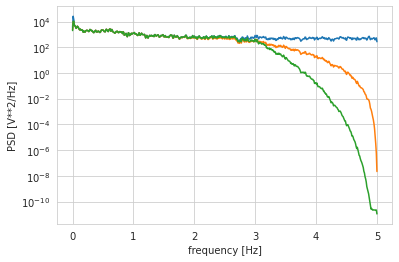

In [41]:
f, Pxx_den = signal.welch(data, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

f, Pxx_den = signal.welch(y, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

f, Pxx_den = signal.welch(y10, ca_fs, nperseg=1024)
plt.semilogy(f, Pxx_den)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [347]:
ca_bp = np.zeros(ca.shape)

for i in tqdm(range(ca.shape[0]), leave=False):
    for j in range(ca.shape[1]):
        y, zo = butter_bandpass_filter(
            data=ca[i, j],
            lowcut=lowcut,
            highcut=highcut,
            fs=ca_fs,
            order=2,
        )
        ca_bp[i, j] = y

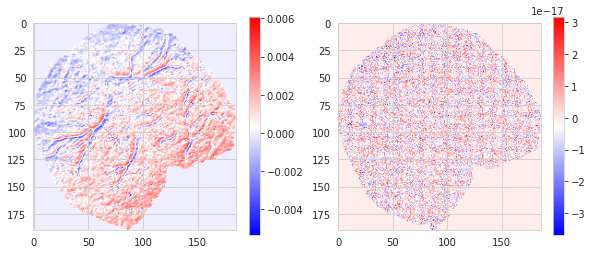

In [351]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(ca_bp.mean(-1), cmap='bwr')
plt.colorbar()

plt.subplot(122)
plt.imshow(ca.mean(-1), cmap='bwr')
plt.colorbar()

plt.show()

### Downsample

In [415]:
size = 16
widths = [int(np.ceil(item / size)) for item in ca.shape[:2]]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca_bp[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(16, 16, 21600)

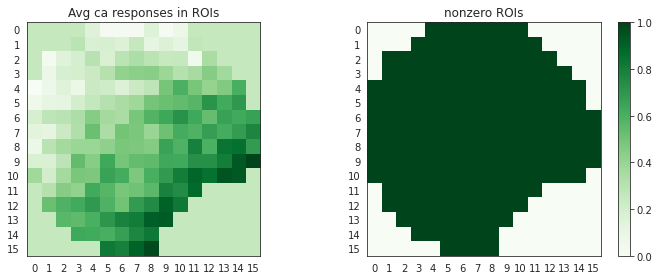

In [416]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[np.abs(data)>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [417]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [418]:
pearson_corr = df.corr('pearson').values
spearman_corr = df.corr('spearman').values

np.fill_diagonal(pearson_corr, 0)
np.fill_diagonal(spearman_corr, 0)

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85]
pearson, spearman = {}, {}
for th in thresholds:
    pmat = pearson_corr.copy()
    smat = spearman_corr.copy()
    pmat[pmat<th] = 0.
    smat[smat<th] = 0.
    pearson[th] = pmat
    spearman[th] = smat

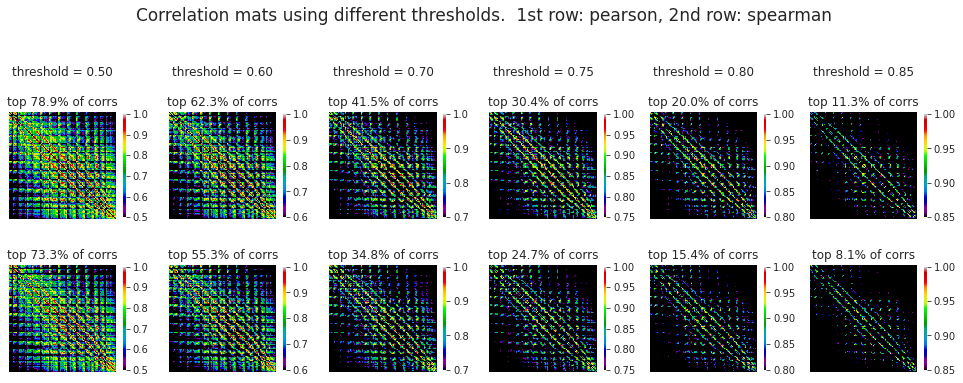

In [419]:
fig, axes = plt.subplots(2, len(thresholds), figsize=(13.5, 5.5))

for i, th in enumerate(thresholds):
    sns.heatmap(
        pearson[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40, 'shrink': 0.6},
        ax=axes[0, i]
    )
    axes[0, i].set_aspect('equal')
    axes[0, i].set_axis_off()
    msg = 'threshold = {:.2f}\n\ntop {:.1f}{:s} of corrs'
    msg = msg.format(th, (pearson[th]>0).sum() / len(pearson[th]) ** 2 * 100, '%')
    axes[0, i].set_title(msg)
    sns.heatmap(
        spearman[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40, 'shrink': 0.6},
        ax=axes[1, i]
    )
    axes[1, i].set_aspect('equal')
    axes[1, i].set_axis_off()
    msg = 'top {:.1f}{:s} of corrs'
    msg = msg.format((spearman[th]>0).sum() / len(spearman[th]) ** 2 * 100, '%')
    axes[1, i].set_title(msg)

msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
fig.suptitle(msg, y=1.03, fontsize=17)
fig.tight_layout()
plt.show()

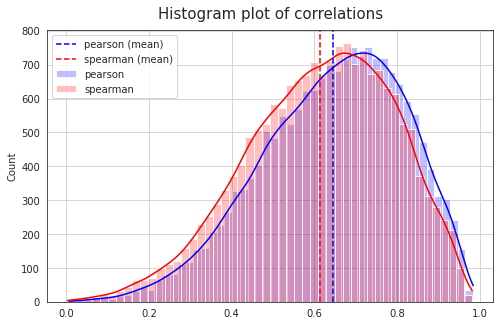

In [420]:
xp = np.triu(pearson_corr)
xs = np.triu(spearman_corr)
xp = xp.flatten()
xs = xs.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.25, label='pearson')
sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.25, label='spearman')
plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
plt.axvline(xp[xp>0.0].mean(), color='b', ls='--', lw=1.5, label='pearson (mean)')
plt.axvline(xs[xs>0.0].mean(), color='r', ls='--', lw=1.5, label='spearman (mean)')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [422]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}

g = nx.from_numpy_matrix(spearman[0.8])

In [360]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

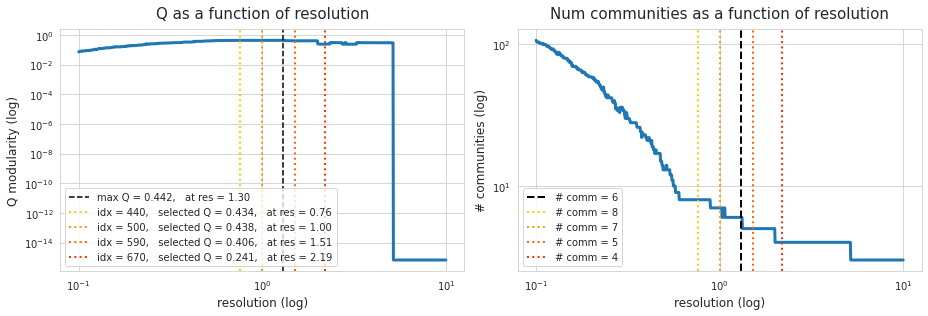

In [364]:
# HIDE CODE


selected_idxs = [440, 500, 590, 670]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='k', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

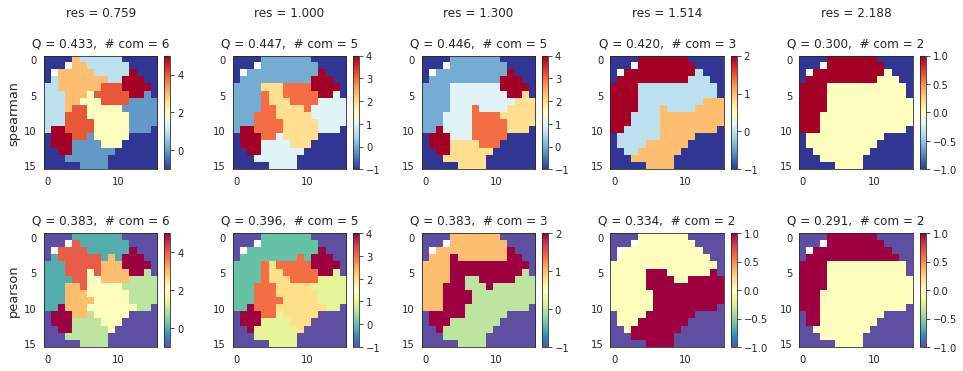

In [366]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(2, len(plot_idxs), figsize=(13.5, 5.5))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    
    g = nx.from_numpy_matrix(spearman[0.8])
    partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[0, ii].set_title(msg, y=1.03)
    
    
    g = nx.from_numpy_matrix(pearson[0.8])
    partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
    msg = 'Q = {:.3f},  # com = {:d}'
    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[1, ii].set_title(msg, y=1.03)
    
    if ii == 0:
        axes[0, ii].set_ylabel('spearman', fontsize=13)
        axes[1, ii].set_ylabel('pearson', fontsize=13)
    
    
fig.tight_layout()
plt.show()

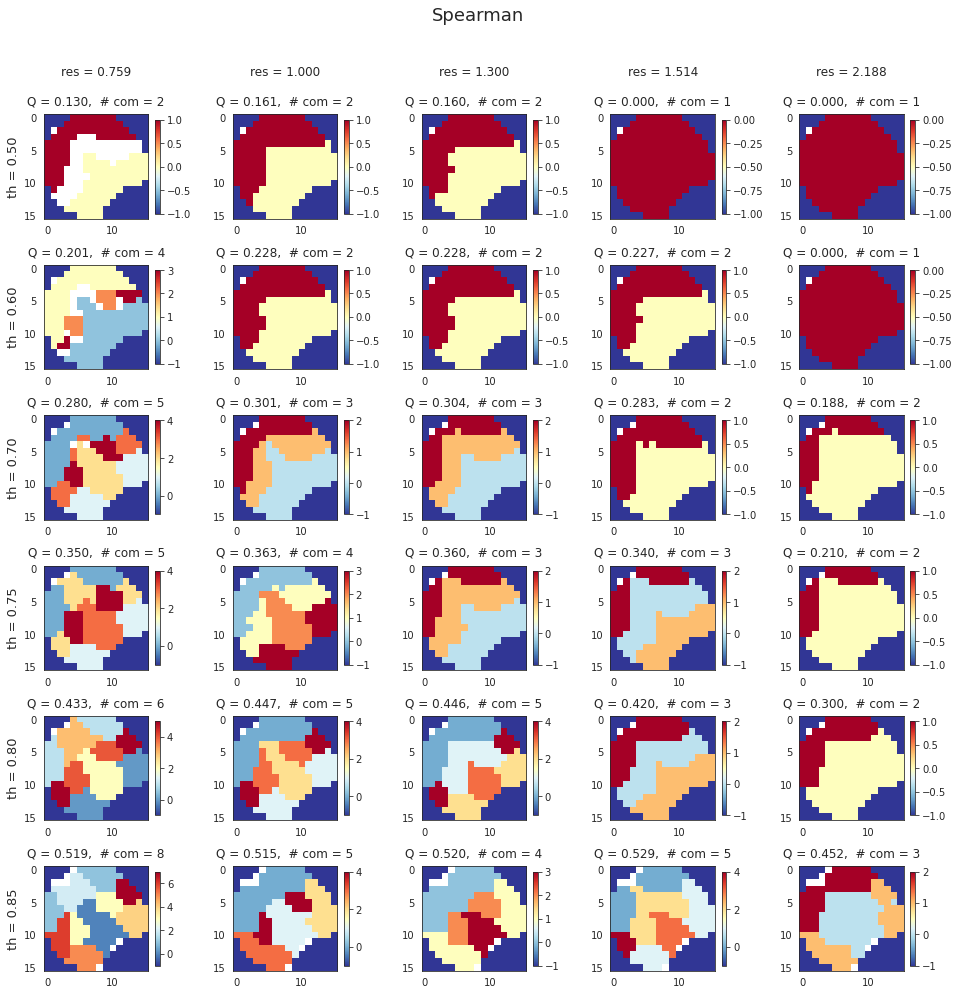

In [368]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(spearman.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='RdYlBu_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Spearman', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

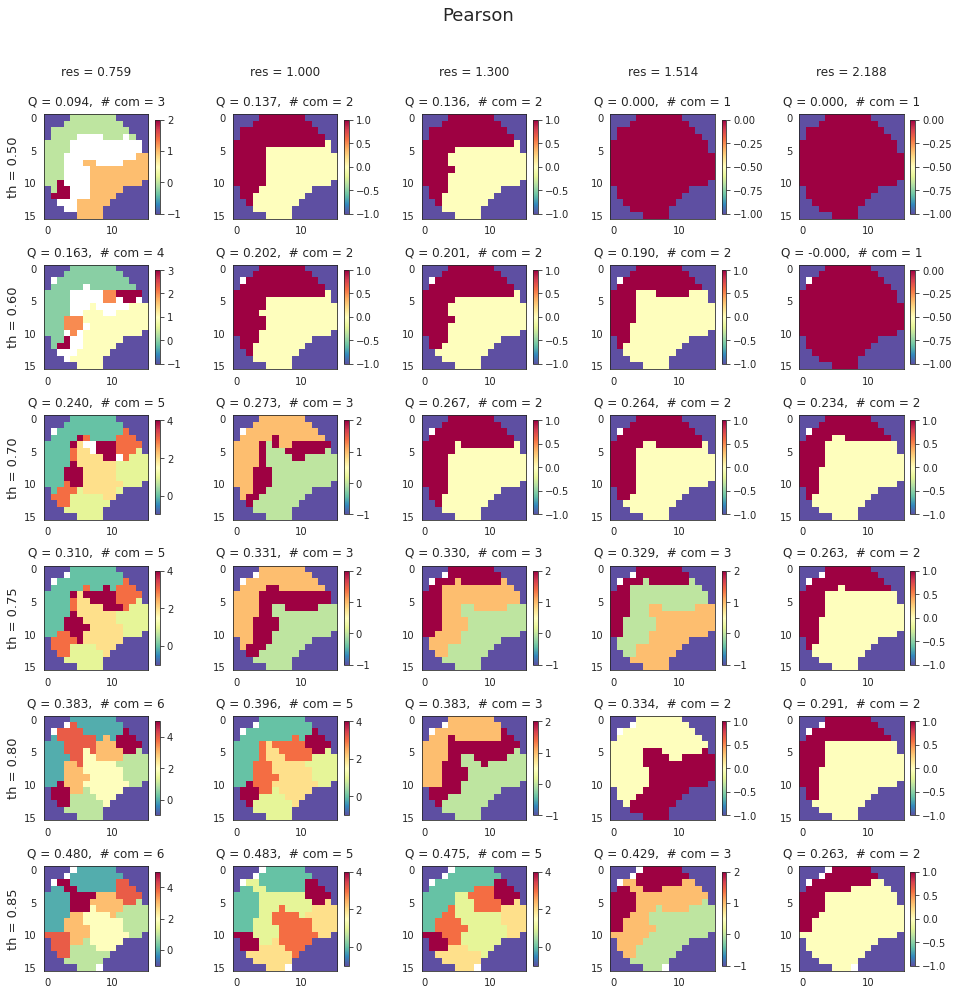

In [369]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(pearson.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Pearson', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

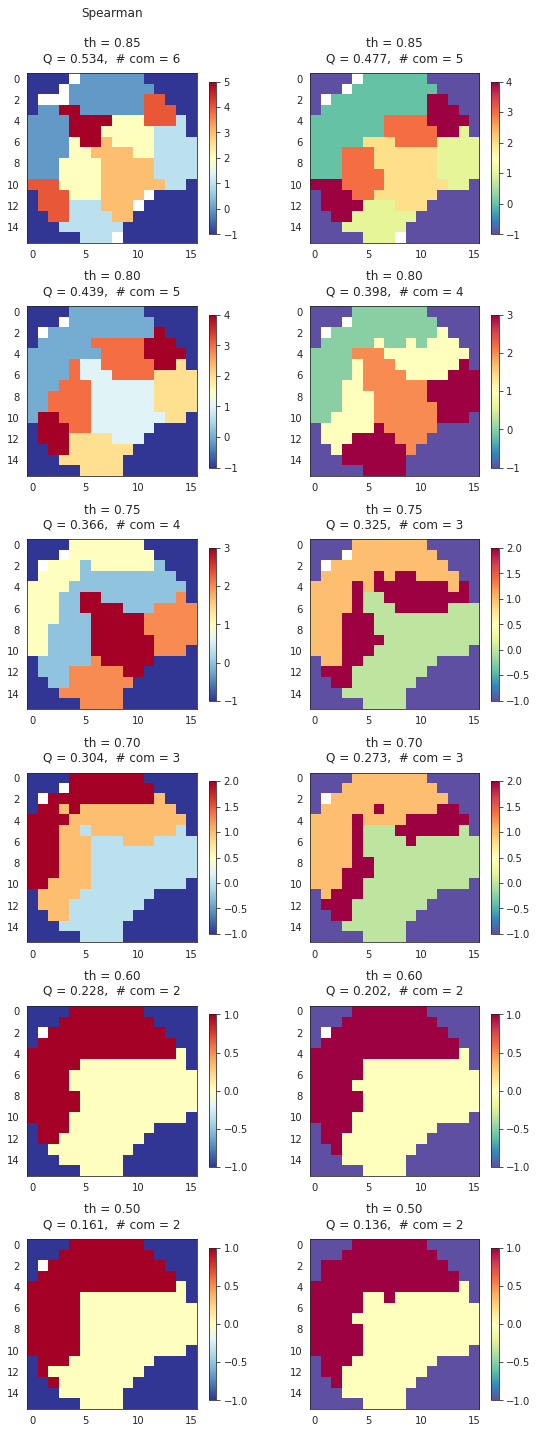

In [426]:
sns.set_style('white')
fig, axes = plt.subplots(len(thresholds), 2, figsize=(8, 20))

for ii, th in enumerate(thresholds[::-1]):
    g = nx.from_numpy_matrix(spearman[th])
    coms = algorithms.leiden(g)
    partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[ii, 0].imshow(comm_mat, interpolation='none', cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
    if ii == 0:
        msg = 'Spearman\n\n'
    else:
        msg = ''
    msg += 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[ii, 0].set_title(msg, y=1.03)
    
    g = nx.from_numpy_matrix(pearson[th])
    coms = algorithms.leiden(g)
    partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[ii, 1].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
    if ii == 0:
        msg = 'Pearson\n\n'
    else:
        msg = ''
    msg = 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[ii, 1].set_title(msg, y=1.03)
    
fig.tight_layout()
plt.show()

## Finer resolution

In [427]:
size = 32
widths = [int(np.ceil(item / size)) for item in ca.shape[:2]]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca_bp[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(32, 32, 21600)

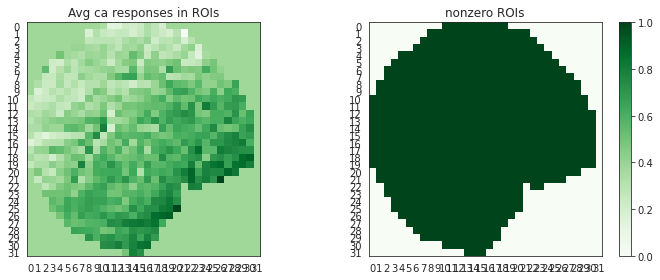

In [428]:
sns.set_style('white')

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(downsampled.mean(-1), cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data = np.abs(downsampled).mean(-1)>0

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [429]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [430]:
pearson_corr = df.corr('pearson').values
spearman_corr = df.corr('spearman').values

np.fill_diagonal(pearson_corr, 0)
np.fill_diagonal(spearman_corr, 0)

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85]
pearson, spearman = {}, {}
for th in thresholds:
    pmat = pearson_corr.copy()
    smat = spearman_corr.copy()
    pmat[pmat<th] = 0.
    smat[smat<th] = 0.
    pearson[th] = pmat
    spearman[th] = smat

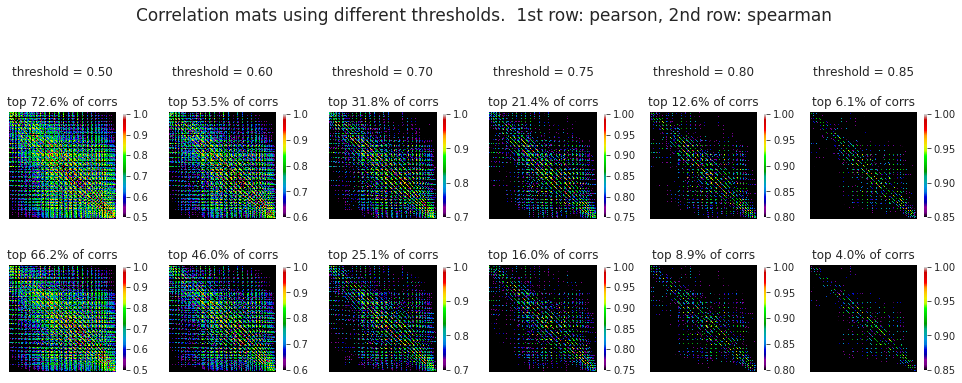

In [431]:
fig, axes = plt.subplots(2, len(thresholds), figsize=(13.5, 5.5))

for i, th in enumerate(thresholds):
    sns.heatmap(
        pearson[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40, 'shrink': 0.6},
        ax=axes[0, i]
    )
    axes[0, i].set_aspect('equal')
    axes[0, i].set_axis_off()
    msg = 'threshold = {:.2f}\n\ntop {:.1f}{:s} of corrs'
    msg = msg.format(th, (pearson[th]>0).sum() / len(pearson[th]) ** 2 * 100, '%')
    axes[0, i].set_title(msg)
    sns.heatmap(
        spearman[th],
        cmap='nipy_spectral',
        vmin=th,
        vmax=1.,
        cbar_kws={'aspect': 40, 'shrink': 0.6},
        ax=axes[1, i]
    )
    axes[1, i].set_aspect('equal')
    axes[1, i].set_axis_off()
    msg = 'top {:.1f}{:s} of corrs'
    msg = msg.format((spearman[th]>0).sum() / len(spearman[th]) ** 2 * 100, '%')
    axes[1, i].set_title(msg)

msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
fig.suptitle(msg, y=1.03, fontsize=17)
fig.tight_layout()
plt.show()

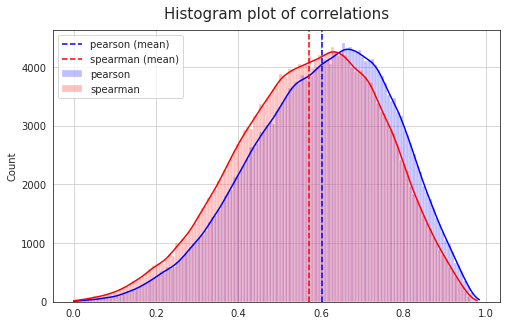

In [432]:
xp = np.triu(pearson_corr)
xs = np.triu(spearman_corr)
xp = xp.flatten()
xs = xs.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.25, label='pearson')
sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.25, label='spearman')
plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
plt.axvline(xp[xp>0.0].mean(), color='b', ls='--', lw=1.5, label='pearson (mean)')
plt.axvline(xs[xs>0.0].mean(), color='r', ls='--', lw=1.5, label='spearman (mean)')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [433]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}

g = nx.from_numpy_matrix(spearman[0.75])

In [377]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

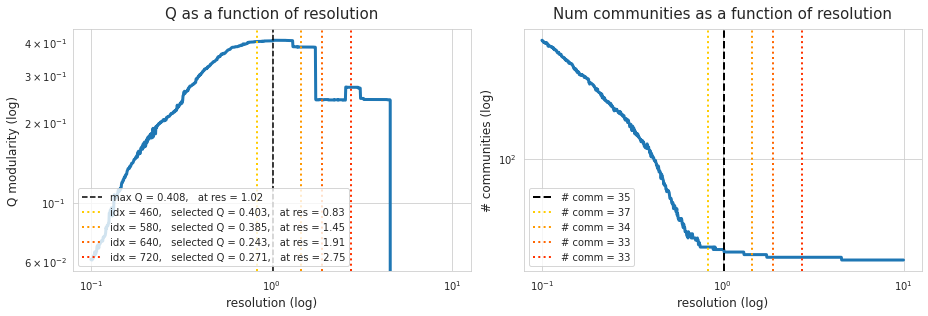

In [380]:
# HIDE CODE


selected_idxs = [460, 580, 640, 720]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='k', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

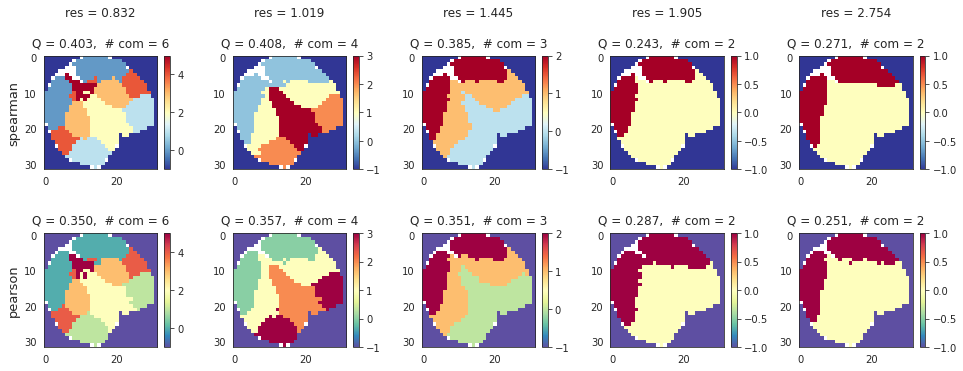

In [381]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(2, len(plot_idxs), figsize=(13.5, 5.5))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    
    g = nx.from_numpy_matrix(spearman[0.75])
    partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[0, ii].set_title(msg, y=1.03)
    
    
    g = nx.from_numpy_matrix(pearson[0.75])
    partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
    msg = 'Q = {:.3f},  # com = {:d}'
    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[1, ii].set_title(msg, y=1.03)
    
    if ii == 0:
        axes[0, ii].set_ylabel('spearman', fontsize=13)
        axes[1, ii].set_ylabel('pearson', fontsize=13)
    
    
fig.tight_layout()
plt.show()

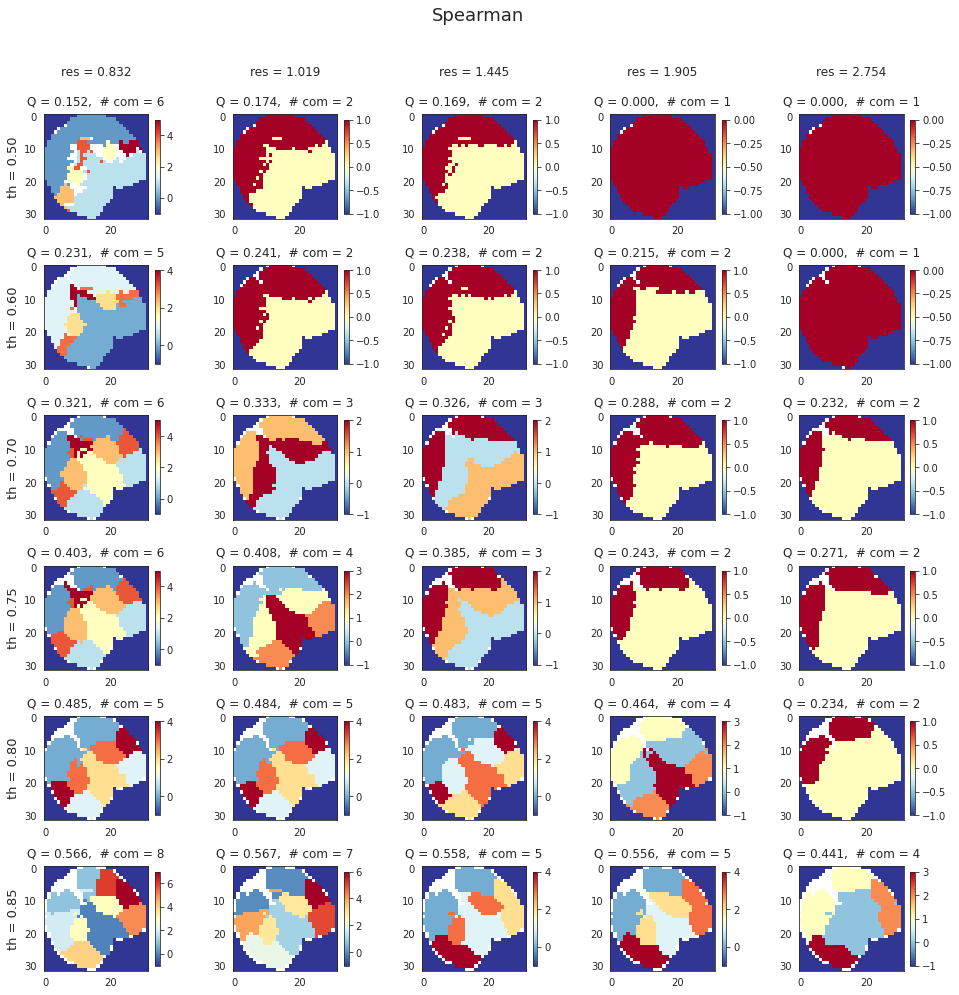

In [382]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(spearman.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='RdYlBu_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Spearman', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

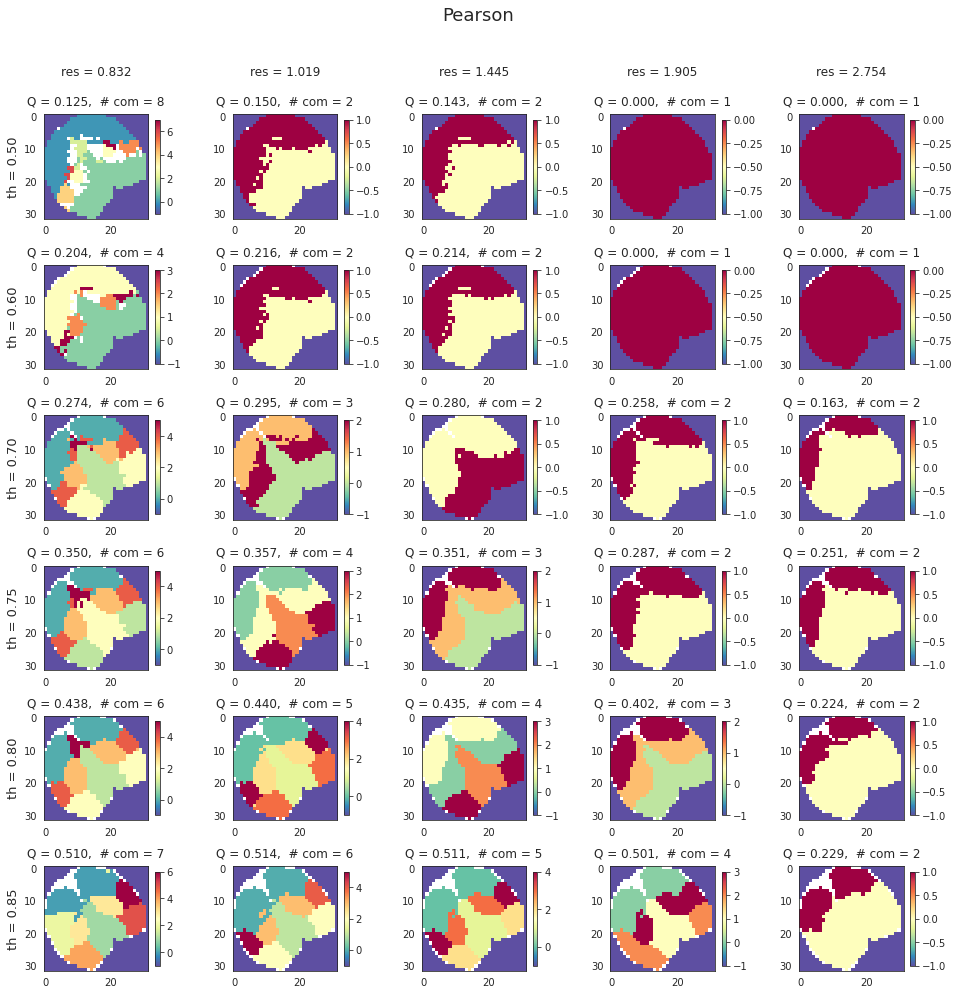

In [383]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=(13.5, 13.5))

for jj, (th, corr) in enumerate(pearson.items()):
    for ii, idx in enumerate(plot_idxs):
        x0 = list(communities_louvain.keys())

        g = nx.from_numpy_matrix(corr)
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[jj, ii].imshow(comm_mat, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[jj, ii], shrink=0.9)
        if jj == 0:
            msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
            msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        else:
            msg = 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[jj, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

fig.suptitle('Pearson', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

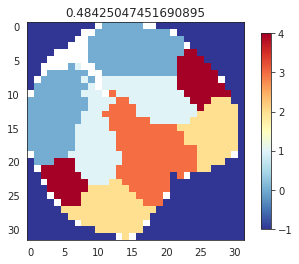

In [410]:
g = nx.from_numpy_matrix(spearman[0.8])
coms = algorithms.leiden(g)
partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
q = nx_comm.modularity(g, communities=comm_dict.values())

im = plt.imshow(comm_mat, cmap='RdYlBu_r')
plt.title(q)
plt.colorbar(shrink=0.9)

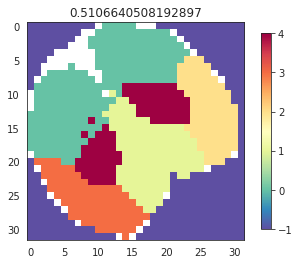

In [411]:
g = nx.from_numpy_matrix(pearson[0.85])
coms = algorithms.leiden(g)
partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
q = nx_comm.modularity(g, communities=comm_dict.values())

im = plt.imshow(comm_mat, cmap='Spectral_r')
plt.title(q)
plt.colorbar(shrink=0.9)

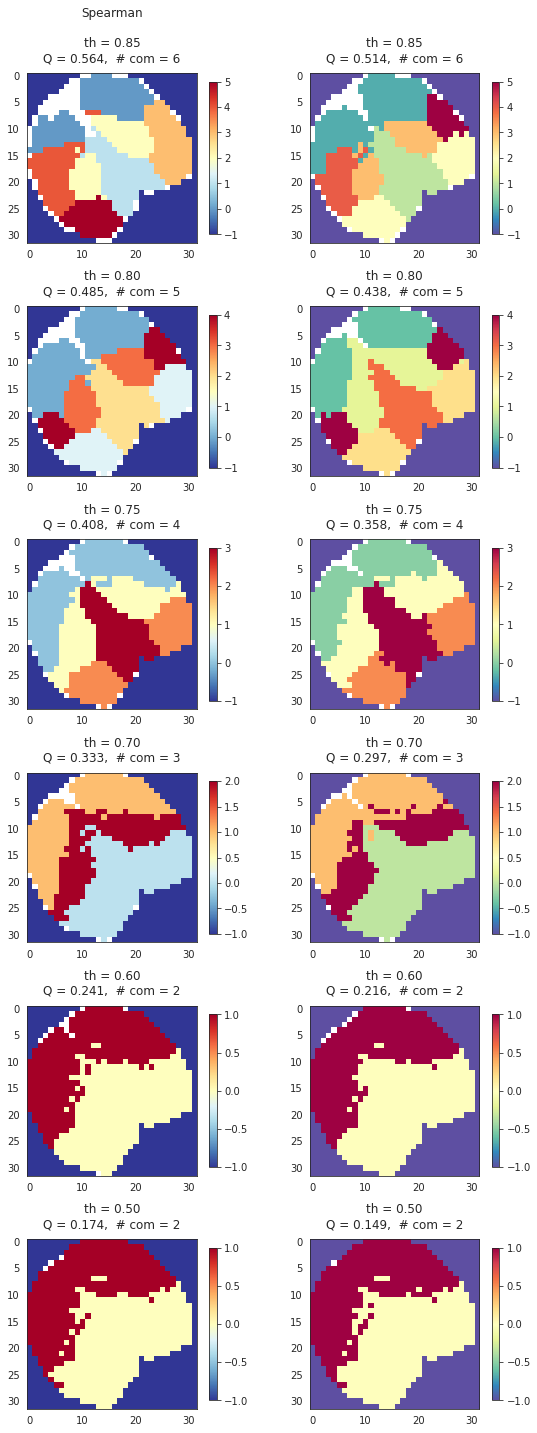

In [434]:
sns.set_style('white')
fig, axes = plt.subplots(len(thresholds), 2, figsize=(8, 20))

for ii, th in enumerate(thresholds[::-1]):
    g = nx.from_numpy_matrix(spearman[th])
    coms = algorithms.leiden(g)
    partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[ii, 0].imshow(comm_mat, interpolation='none', cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
    if ii == 0:
        msg = 'Spearman\n\n'
    else:
        msg = ''
    msg += 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[ii, 0].set_title(msg, y=1.03)
    
    g = nx.from_numpy_matrix(pearson[th])
    coms = algorithms.leiden(g)
    partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
    comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
    q = nx_comm.modularity(g, communities=comm_dict.values())

    im = axes[ii, 1].imshow(comm_mat, cmap='Spectral_r')
    plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
    if ii == 0:
        msg = 'Pearson\n\n'
    else:
        msg = ''
    msg = 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
    msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
    axes[ii, 1].set_title(msg, y=1.03)
    
fig.tight_layout()
plt.show()